# Install and Import Dependencies

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

 # Loading  Model

In [4]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

Metal device set to: Apple M1 Pro


2022-03-24 11:42:14.782384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-24 11:42:14.782513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Data Processing

In [151]:
# Load the annotated csv
df = pd.read_csv ( "annotated.csv")
df

,name,video_id,Length,0,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,60
0,3869387-preview,279,30,running,running,running,running,running,running,running,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6669347-preview,404,20,walking,walking,walking,walking,walking,walking,walking,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6669362-preview,777,20,walking,walking,walking,walking,walking,walking,walking,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25340660-preview,823,20,walking,walking,walking,walking,walking,walking,walking,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25340660-preview,823,15,running,running,running,running,running,running,running,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,var-models_part2_split_20,1130,61,slides,slides,slides,slides,slides,slides,slides,...,off_screen,standing,standing,standing,standing,standing,standing,standing,standing,standing
1110,var-models_part2_split_21,1131,61,standing,standing,standing,standing,standing,standing,standing,...,slides,slides,slides,slides,slides,slides,slides,standing,standing,standing
1111,var-models_part2_split_22,1133,61,standing,standing,standing,standing,standing,standing,standing,...,standing,standing,standing,standing,standing,standing,standing,standing,standing,standing
1112,var-models_part2_split_23,1132,61,standing,standing,standing,standing,standing,off_screen,off_screen,...,standing,standing,standing,standing,standing,standing,standing,standing,standing,standing


In [152]:
doubt = ['idle','bench_press','triceps','torso_up_double_leg_extension'
,'bear_hold_knee_taps','bear_hold_shoulder_taps','transition','glutes','pulse_ups_right','pulse_ups_left','straight_left_leg_pulse',
'push_hip_up_right_leg_up','hip_up_right_swing_down','push_hip_up_left_leg_up','hip_up_left_swing_down','knees_to_chest','bear_hold',
'front_press','front_up_pulse','front_laying_leg_lifts','front_laying_arms_legs_lifts','high_plank_left_leg_press','strech','stretching',
'fullbody_walkouts','down_dog','up_dog','runners_lundge_reach','table_top','all_fours','reverse_dog_crunch','knees_to_elbow',
'all_fours_drive','pace_skips','criss_cross','donkey_press','table_top_position_idle','upper_body_up_double_leg_extension','adjusting','pointing']





idle_standing = ['walking','standing','standing,talking','talking,walking','talking','standing_idle','standing_writing'
                ,'walking_idle']

idle_sitting = ['sitting','sitting_idle']

idle_lyingdown = ['laying_flat','laying_down_idle','laydown_faceup','laying_down_face_up','front_laying_position'
                ,'laying_down_flat','laydown_face_up','laydown_flat','front_laying_idle']

workout_standing = ['jump_rope','jumping_jacks','dancing','pullups','jumping','hanging','high_knees',
                    'agility_feet','x_jumps','run_in_place','standing_skips',
                    'running','wall_pushups','boxing','high_knee_sprint','high_knee_sprints']

workout_transition =['bodyweight_squats','lateral_lunges','lunges','squats','body_weight_squats','skii_hops',
                    'body_weight_squat_toes','squat_jumps','lateral_squad_jumps','lateral_squat_jumps','drop_squats','surfer_hops',
                    'lateral_squat_walk_reverse_lundge','burpy_crawl_combo','squat_hold_reverse_lundge','burpy',
                     'split_hop','lower_knee_hop','lateral_squat_walk_reverse_lundge','lateral_shuffle','shuffle_position']

workout_lyingdown = ['pushups','crunches','plank_dynamic','plank_static','side_plank_dynamic','mountain_climbers',
                    'plank','fire_hydrants','roll_up','alternating_deadbug','single_bent_leg_lower','double_bent_leg_lower',
                    'double_leg_extension', 'upper_body_up_criss_cross','bear_hold_taps','bear_crawl','forward_plank',
                    'left_side_plank','right_side_plank','arm_plank','modified_arm_plank','left_side_plank_reaching',
                     'right_side_plank_reaching','kickbacks_right_glute','hamstring_curl_right','straight_right_leg_pulse',
                    'kickbacks_left_glute','hip_bridge','cross_crunches','forearm_plank','high_plank','high_plank_right_leg_press',
                    'push_hip_up_right_leg','push_hip_up_left_leg','up_down_dog','mountain_climber','cat_cow','all_fours_elbow_spine_stretch',
                     'lay_down_knees_up','lay_down_one_knee_up','lay_down_knee_up_down','lay_down_knee_swing_shoulder_blades_up','forearm_plank_rocking',
                     'loaded_beast_push_up','modified_push_ups','hamstring_curl_left','high_plank_shoulder_feet_combo','straight_leg_lifts','all_fours_warm_up',
                    'all_fours_idle','kneeling_idle']

workout_yoga_strectching = ['yoga,stretching','streching','yoga,','yoga,ground','yoga,all_four','yoga,standing']

remove = ['slides', 'off_screen', 'slide', 'pointing', 'offscreen','intro_page']

In [153]:
def change_actions(x):
    if x in idle_standing:
        return 'Idle_High'
    elif x in idle_sitting:
        return 'idle_sitting'
    elif x in idle_lyingdown:
        return 'Idle_Low'
    elif x in workout_standing:
        return 'Workout_High'
    elif x in workout_transition:
        return 'Workout_Transition'
    elif x in workout_lyingdown:
        return 'Workout_Low'
    elif x in workout_yoga_strectching:
        return 'yoga/strectching'
    elif x in remove:
        return 'remove'
    elif x in doubt:
        return "doubt"
    else:
        return x
    

In [154]:
req = df.iloc[:,3:].values.tolist()
flatten = [items for lists in req for items in lists]
flatten = [x for x in flatten if str(x) != 'nan']
count_dict={}
for action in flatten:
    if action in count_dict:
        count_dict[action]+=1
    else:
        count_dict[action]=1

count =pd.DataFrame.from_dict(count_dict,orient = 'index')
count.reset_index(inplace=True)
count = count.rename(columns = {'index':'actions'})

count['six_class' ]= count['actions'].apply(lambda x: change_actions(x))

In [155]:
count.groupby(['six_class'])[0].sum()

six_class
Idle_High             5268
Idle_Low                94
Workout_High          3066
Workout_Low           4071
Workout_Transition    1862
doubt                 1777
idle_sitting           226
remove                 654
yoga/strectching      1715
Name: 0, dtype: int64

In [165]:
data = pd.read_csv("coordinates.csv", index_col = 0)
data.dropna( axis=0,  inplace=True)
data

,video_id,frame_count,fps,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,actions
0,279,1,29,0.194167,0.474421,0.177525,0.486390,0.177479,0.467132,0.190676,...,0.514983,0.620077,0.467754,0.627111,0.503399,0.782260,0.464268,0.773160,0.460820,running
1,279,2,29,0.194559,0.473831,0.179554,0.483210,0.179706,0.468016,0.191008,...,0.516670,0.620963,0.461590,0.638270,0.504532,0.774690,0.468995,0.771903,0.470143,running
2,279,3,29,0.196080,0.468627,0.181912,0.478633,0.180850,0.463631,0.193267,...,0.508290,0.620228,0.462210,0.622819,0.478843,0.778599,0.492166,0.774354,0.489078,running
3,279,4,29,0.196092,0.468655,0.181905,0.478662,0.180863,0.463647,0.193274,...,0.508061,0.619862,0.462096,0.622813,0.479078,0.778002,0.492249,0.774339,0.489007,running
4,279,5,29,0.197715,0.467405,0.184015,0.475692,0.181017,0.464770,0.194321,...,0.515078,0.615721,0.476758,0.614663,0.496875,0.777589,0.512477,0.772853,0.513822,running
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559047,1128,1756,29,0.369264,0.427513,0.351490,0.429317,0.354096,0.416672,0.350904,...,0.382743,0.804711,0.445376,0.826067,0.401656,0.954128,0.432958,0.944596,0.415342,walking
559048,1128,1757,29,0.369439,0.428200,0.352076,0.429936,0.354834,0.417667,0.352572,...,0.381743,0.807297,0.441704,0.825380,0.399921,0.953517,0.430752,0.940221,0.412758,walking
559049,1128,1758,29,0.371266,0.427900,0.353715,0.429250,0.357135,0.417058,0.352838,...,0.379473,0.805639,0.437797,0.826095,0.397931,0.954819,0.430333,0.939026,0.410947,walking
559050,1128,1759,29,0.372162,0.427443,0.354611,0.428730,0.358167,0.416442,0.353902,...,0.376918,0.815868,0.436354,0.827735,0.396352,0.957337,0.430134,0.940548,0.411525,walking


In [166]:
data['target' ]= data['actions'].apply(lambda x: change_actions(x))
data.drop(['actions'] , axis = 1,inplace = True)
data.head()

,video_id,frame_count,fps,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,target
0,279,1,29,0.194167,0.474421,0.177525,0.486390,0.177479,0.467132,0.190676,...,0.514983,0.620077,0.467754,0.627111,0.503399,0.782260,0.464268,0.773160,0.460820,Workout_High
1,279,2,29,0.194559,0.473831,0.179554,0.483210,0.179706,0.468016,0.191008,...,0.516670,0.620963,0.461590,0.638270,0.504532,0.774690,0.468995,0.771903,0.470143,Workout_High
2,279,3,29,0.196080,0.468627,0.181912,0.478633,0.180850,0.463631,0.193267,...,0.508290,0.620228,0.462210,0.622819,0.478843,0.778599,0.492166,0.774354,0.489078,Workout_High
3,279,4,29,0.196092,0.468655,0.181905,0.478662,0.180863,0.463647,0.193274,...,0.508061,0.619862,0.462096,0.622813,0.479078,0.778002,0.492249,0.774339,0.489007,Workout_High
4,279,5,29,0.197715,0.467405,0.184015,0.475692,0.181017,0.464770,0.194321,...,0.515078,0.615721,0.476758,0.614663,0.496875,0.777589,0.512477,0.772853,0.513822,Workout_High


# Helper Functions

In [167]:
# To processes the video and retrun the coordinates per frame

def video_processing(name):
    points = []
    cap = cv2.VideoCapture(name)
    while cap.isOpened():
        success, frame = cap.read()

        if not success:
                break


        # Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)

        # Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

        points.append(keypoints_with_scores[0][:, :2].flatten())


        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
    print("video processed")

    cap.release()
    return points

In [168]:
# Annotating the video with output lable


def video_output(points,name, n, step, model):
    # Predicting

    test_df = pd.DataFrame(points)
    test_df = data_transform(test_df,n,step , test =True)
    result = model.predict(test_df)
    shape = result.shape[0]
    pred_list=[]
    
    from moviepy.editor import VideoFileClip
    clip = VideoFileClip(name)
    time = clip.duration
    #print(time)
    
    pred_list = []

    shape = len(result)
    frame_to_stack = int(round(shape/time))
    
    for i in range(0, shape, frame_to_stack):
        pred_list.append(stats.mode(result[i: i+frame_to_stack])[0][0])
    
    pred_masked = pred_list[:]
    
    for i in range(1,len(pred_list)-1):
        if ((pred_masked[i] != pred_masked[i-1]) and (pred_masked[i] != pred_masked[i+1]) and (pred_masked[i-1] == pred_masked[i+1])):
            pred_masked[i] = pred_masked[i-1]

        if ((pred_masked[i] != pred_masked[i-1]) and (pred_masked[i] != pred_masked[i+1]) and (pred_masked[i-1] != pred_masked[i+1])):
            pred_masked[i] = pred_masked[i-1]


    cap = cv2.VideoCapture(name)
    #print("Frames to stack" , frame_to_stack)

    fps= int(cap.get(cv2.CAP_PROP_FPS))
    
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    video_out = name[:-4] +"_after_inference.mp4"

    out = cv2.VideoWriter(video_out,cv2.VideoWriter_fourcc('D','I','V','X'), fps, (frame_width,frame_height))
    frame_count = 1
    time_stamp = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success or time_stamp == len(pred_masked):
            break
        
        #Display Text
        cv2.putText(frame, str(pred_masked[time_stamp]),
                            (10, 100),
                            cv2.FONT_HERSHEY_PLAIN, 5, (0, 0, 255), 2, cv2.LINE_AA)
        
          
        out.write(frame)
        frame_count+=1
        if frame_count % fps == 0:
            time_stamp+=1
    print("Video Rendered")
    cap.release()
    out.release()

# XGBoost Modelling

In [169]:
# Moment

from scipy import stats

# Function to return the diffrence in coordinate of xth frame and x+nth frame
def data_transform(data, n, step, test =False):
    
    if test == False:
        segments = []
        labels = []
        video_id = []
        for id in data['video_id'].unique():
            sub_set = data[data["video_id"] == id]
            for i in range(0, sub_set.shape[0] - n, step):

                values = ((sub_set.iloc[i+n, 3:37] - sub_set.iloc[i, 3:37]) / sub_set.iloc[i+n, 3:37])

                label = stats.mode(sub_set['target'][i: i+n])[0][0]

                #video_id.append(id)
                segments.append([values.append(sub_set.iloc[i+n, 3:37])])
                labels.append(label)
        
                

        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,68)
        #video_id = np.asarray(video_id)
        df = pd.DataFrame(reshaped_segments)
        #df.insert(0, "video_id", video_id)
        df['target'] = labels  
        
        return(df)
    
        

    else:
        segments = []
        data = pd.DataFrame(points)
      
        for i in range(0, data.shape[0] - n, step):

            values = ((data.iloc[i+n, :] - data.iloc[i, :]) / data.iloc[i+n, :])
            segments.append([values.append(data.iloc[i+n, :])])
    
                

        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,68)

        
        return(reshaped_segments)
  
# XG Boost Classifier

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score


def model_xgb(X_train, y_train, X_test, y_test, cf_matrix = False):
    
    # Create a classifier
    xgb = XGBClassifier(objective=  'multi:softmax' , random_state =42 )

    # Fit the classifier with the training data
    xgb.fit(X_train,y_train)

    # Use trained model to predict output of test dataset
    predictions  = xgb.predict(X_test) 
    preds_probs = xgb.predict_proba(X_test)
    
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    f1 = f1_score(y_test, predictions, average='macro')
    precision = precision_score(y_test, predictions,average = 'micro', pos_label=1)
    recall = recall_score(y_test, predictions,average = 'micro', pos_label=1)
   
    print("ACCURACY PER INSTANCE:" ,accuracy)
    print("F1_score:" ,f1)
    print("Precision:", precision)
    print("Recall:",recall)
    
    (unique,count) = np.unique(y_train, return_counts=True)
    
    class_labels = unique


    # plotting confusion matrix
    
    if cf_matrix == True:

        plt.figure(figsize = (16,6))
        sns.heatmap(pd.DataFrame(confusion_matrix(y_test , predictions)),annot=True, fmt="d",
                    xticklabels = class_labels, yticklabels = class_labels)

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        print(classification_report(y_test, predictions))
        plt.show()

    return (xgb, predictions, preds_probs, accuracy, f1, precision, recall )


In [170]:
data.groupby("target").size()

target
Idle_High             151459
Idle_Low                2730
Workout_High           80254
Workout_Low           124060
Workout_Transition     60219
doubt                  54751
idle_sitting            6249
remove                 18712
yoga/strectching       60443
dtype: int64

In [558]:
from sklearn.model_selection import train_test_split

data_transformed = data_transform(data, 5,5)

remove_from_target = ['doubt', 'remove','yoga/strectching','idle_sitting']

data_transformed = data_transformed[~data_transformed['target'].isin(remove_from_target)]

print(data_transformed.groupby("target").size())


X = data_transformed.iloc[:,:-1]
y =data_transformed['target']



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, shuffle  = True)

target
Idle_High             30167
Idle_Low                543
Workout_High          15692
Workout_Low           24663
Workout_Transition    11927
dtype: int64


[00:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ACCURACY PER INSTANCE: 0.9507904376325429
F1_score: 0.9236483645613411
Precision: 0.9507904376325429
Recall: 0.9507904376325429
                    precision    recall  f1-score   support

         Idle_High       0.96      0.96      0.96      7542
          Idle_Low       0.94      0.75      0.83       135
      Workout_High       0.92      0.92      0.92      3923
       Workout_Low       0.96      0.97      0.97      6166
Workout_Transition       0.95      0.92      0.93      2982

          accuracy                           0.95     20748
         macro avg       0.95      0.91      0.92     20748
      weighted avg       0.95      0.95      0.95     20748



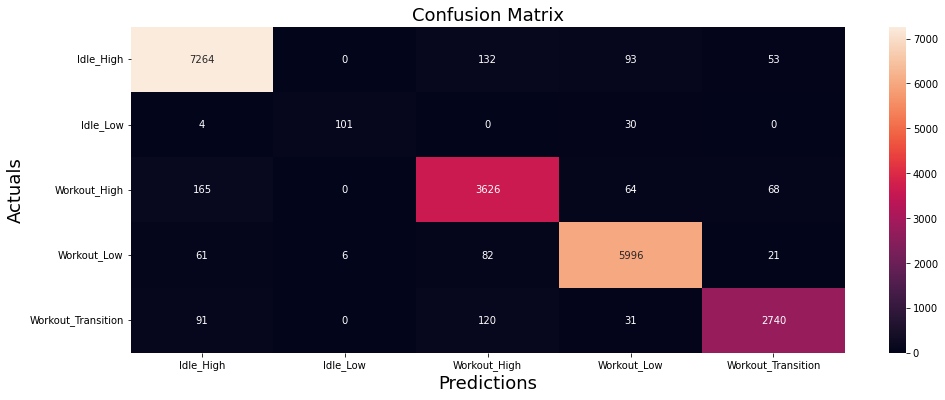

In [559]:
#5,5 - No -sampling - Moment

model, predictions , preds_probs, accuracy, f1, precision, recall = model_xgb(X_train, y_train, X_test, y_test, cf_matrix =True)

In [560]:
import pickle

# save the model to disk
filename = 'model_5_5_final.sav'
pickle.dump(model, open(filename, 'wb'))